# 3 从零开始搭建扩散模型


## 3.1 环境准备

In [ ]:
# !pip install -q diffusers

In [10]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [11]:
dataset = torchvision.datasets.MNIST(root="/mnt/71f67401-292d-4824-b42d-45020abbdd27/dataset/d2l/data",
                                     train=True,
                                     download=True,
                                     transform=torchvision.transforms.ToTensor()
                                     )

In [12]:
train_dataloader = DataLoader(dataset,
                              batch_size=8,
                              shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])  x.shape[0]: 8
Labels: tensor([4, 2, 1, 1, 6, 1, 4, 8])  Labels.shape: torch.Size([8])


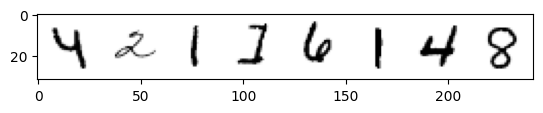

In [13]:
"""
一个训练batch的训练数据
"""
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape,' x.shape[0]:',x.shape[0])
print('Labels:', y,' Labels.shape:',y.shape)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 3.2 扩散模型之退化过程（加噪过程）

In [26]:
"""
加噪过程函数(这里没有采用DDPM的加噪公式)
- amount=0:不做任何更改
- amount=1:得到纯粹的噪声
"""
def corrupt(x, amount):
  """根据amount为输入x加入噪声，这就是退化过程"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # 整理形状以保证广播机制不会出错（dataloader中，x.shape=[batch_size,c,h,w]）
  # print('amount.view:',amount.shape)
  return x*(1-amount) + noise*amount


amount.shape: torch.Size([8])
amount.view: torch.Size([8, 1, 1, 1])


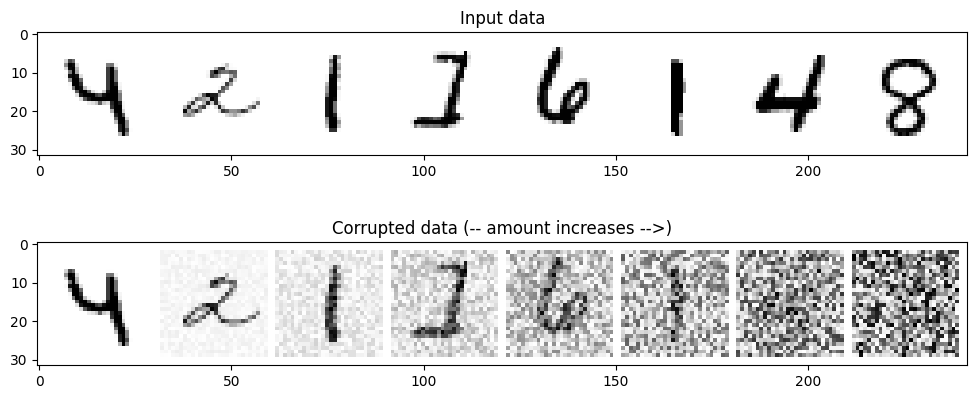

In [20]:
"""
对输出的结果进行可视化，观察其是否符合预期
"""
# Plotting the input data
# 绘制输入数据
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
print('amount.shape:',amount.shape)
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## 3.3 扩散模型之训练

![UNet结构图](./imgs/3_1.png)

模型输入的是加噪后的数据，输出的是原始数据

In [21]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)  # 使用最大池化层进行下采样
        self.upscale = nn.Upsample(scale_factor=2)  # 使用nn.Upsample模块进行上采样

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function（通过运算层与激活函数）
            if i < 2: # For all but the third (final) down layer:（选择除了第三层（最后一层）以外的层）
              h.append(x) # Storing output for skip connection（排列供残差连接使用的数据）
              x = self.downscale(x) # Downscale ready for the next layer（进行下采样以适配下一层的输入）

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer（选择除了第一个上采样层以外的层）
              x = self.upscale(x) # Upscale（Upscale上采样）
              x += h.pop() # Fetching stored output (skip connection)（得到之前排列好的供残差连接使用的数据）
            x = self.act(l(x)) # Through the layer and the activation function（通过运算层与激活函数）

        return x

In [23]:
"""
检查输出形状是否正确
"""
net = BasicUNet()
x = torch.rand([8, 1, 28, 28])
net(x).shape

torch.Size([8, 1, 28, 28])

In [24]:
# 统计参数
sum([p.numel() for p in net.parameters()])

309057

Finished epoch 0. Average loss for this epoch: 0.026687
Finished epoch 1. Average loss for this epoch: 0.020278
Finished epoch 2. Average loss for this epoch: 0.018682


(0.0, 0.1)

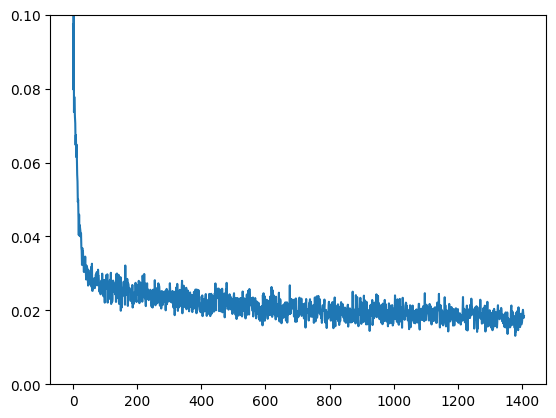

In [27]:
"""
给定带噪的输入noisy_x，模型输出原始输入x的最佳预测，通过均方误差(MSE)对预测值与真实值进行比较
1. 获取一批数据
2. 添加随机噪声
3. 将数据输入模型
4. 对模型预测与初始图像进行比较，计算损失更新模型的参数

"""

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
# 设置在整个数据集运行多少个周期
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:  # x:image y:label

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts()
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        # 模型输入的是加噪后的数据，输出的是原始数据
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        # loss.item:返回精确数值
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

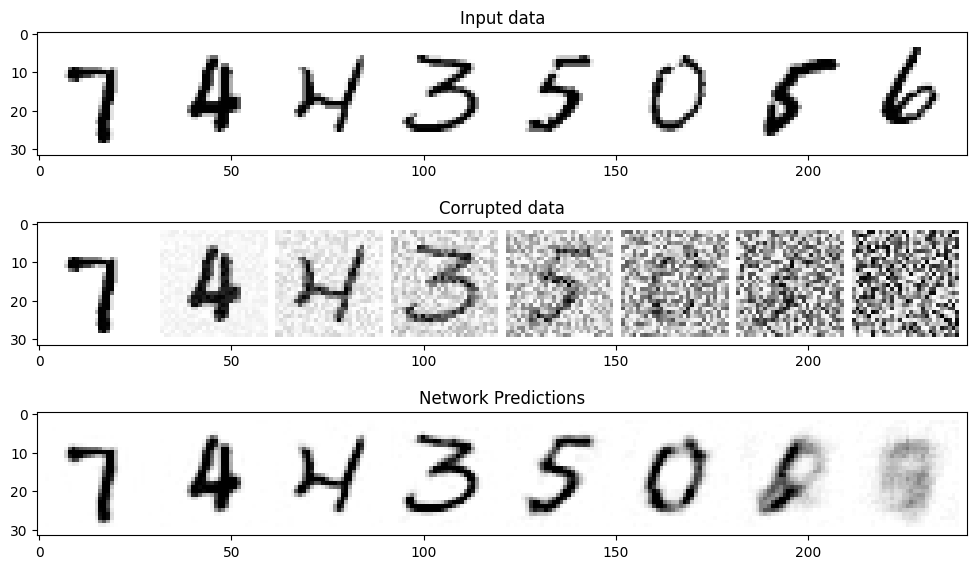

In [28]:
#@markdown Visualizing model predictions on noisy inputs:

"""
对于噪声量较低的输入，模型的预测结果相当不错；
当amount=1时，模型输出一个模糊的预测，该预测很接近数据集的平均值
"""

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')

axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')

axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

## 3.4 扩散模型之采样过程

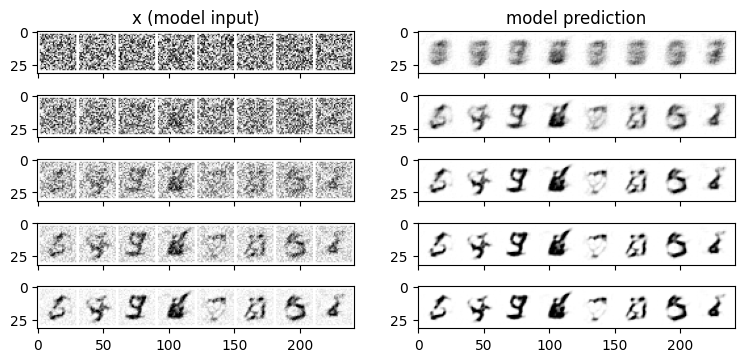

In [35]:
"""
改变采样策略：每次只向前预测一小步
- 把采样过程拆解为5步，每次只前进一步
"""

#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # 从完全随机的值开始
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction（设置朝着预测的方向移动多少）
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there（移动过程）
    step_history.append(x.detach().cpu()) # Store step for plotting（记录每一次的移动，便于绘图）

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

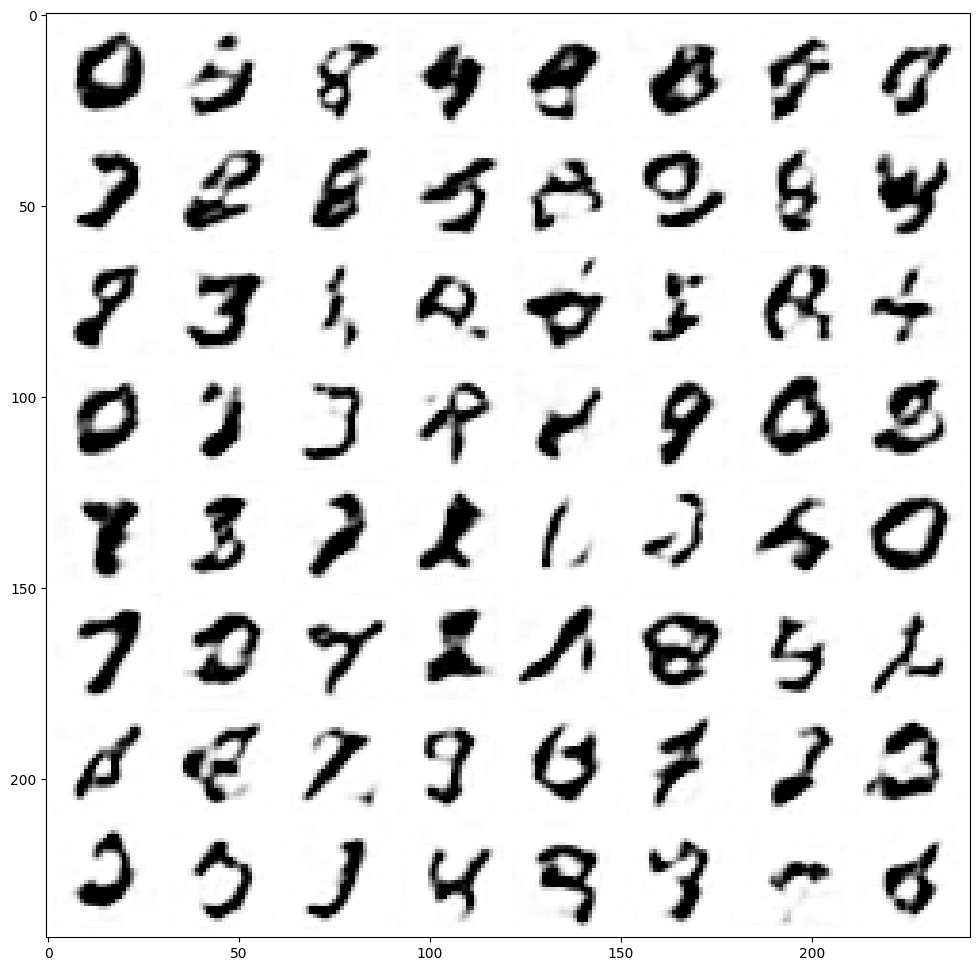

In [40]:
"""
将采样过程拆解为更多步，以获得质量更高的图像
"""

#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

In [42]:
"""
Diffusers库中的UNet2DModel相较于前面的BasicUNet模型作了如下改进：
- GroupNorm层对每个模块的输入进行了组标准化(group normalization)
- Dropout层使训练更平滑
- 每个块有多个ResNet层（如果layers_per_block没有被设置为1）
- 引入了注意力机制（通常仅用于输入分辨率较低的block）
- 可以对时间步进行调节
- 具有可学习参数的上采样模块和下采样模块
"""

model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example

    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block（标准的ResNet下采样模块）
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention（带有空域维度self-att的ResNet下采样模块）
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention（带有空域维度self-att的ResNet上采样模块）
        "UpBlock2D",          # a regular ResNet upsampling block（标准的ResNet上采样模块）
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [43]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

Finished epoch 0. Average loss for this epoch: 0.018284
Finished epoch 1. Average loss for this epoch: 0.012742
Finished epoch 2. Average loss for this epoch: 0.011492


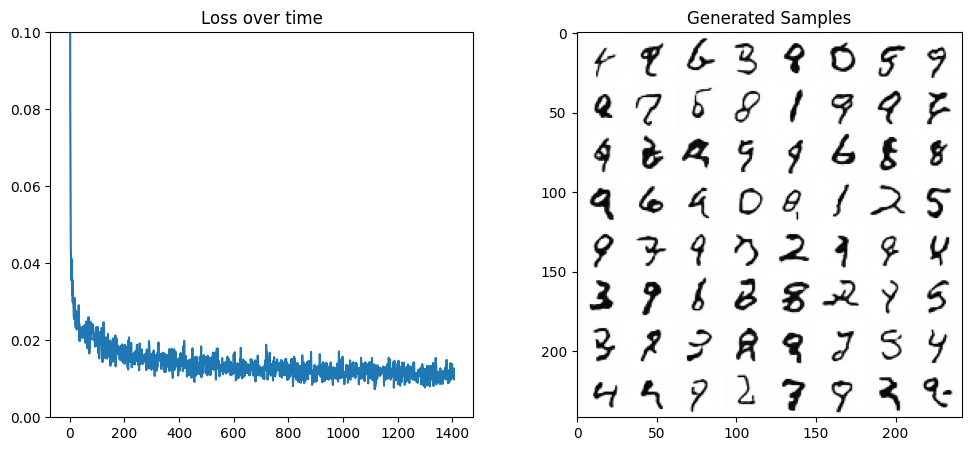

In [44]:
"""
使用UNet2DModel代替之前的BasicModel模型进行训练，输入原始图像与时间步
- t=0:表明模型是在没有时间步的情况下工作
"""

#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

## 3.5 扩散模型之退化过程示例

DDPM中的加噪过程：
\begin{aligned}

\mathbf{x}_t
&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ ;where } \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})

\end{aligned}


In [46]:
#??noise_scheduler.add_noise

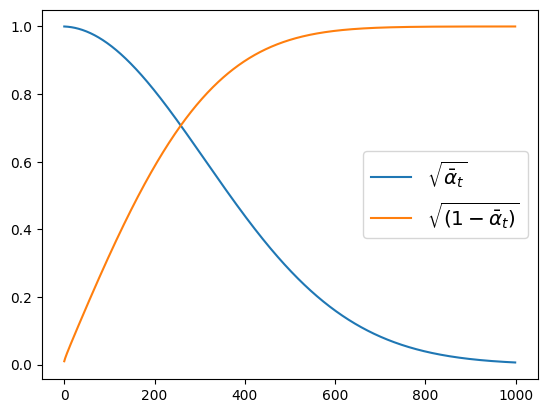

In [47]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

In [51]:
noise_scheduler,type(noise_scheduler)

(DDPMScheduler {
   "_class_name": "DDPMScheduler",
   "_diffusers_version": "0.18.2",
   "beta_end": 0.02,
   "beta_schedule": "linear",
   "beta_start": 0.0001,
   "clip_sample": true,
   "clip_sample_range": 1.0,
   "dynamic_thresholding_ratio": 0.995,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "sample_max_value": 1.0,
   "steps_offset": 0,
   "thresholding": false,
   "timestep_spacing": "leading",
   "trained_betas": null,
   "variance_type": "fixed_small"
 },
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler)

Text(0.5, 1.0, 'Noisy X')

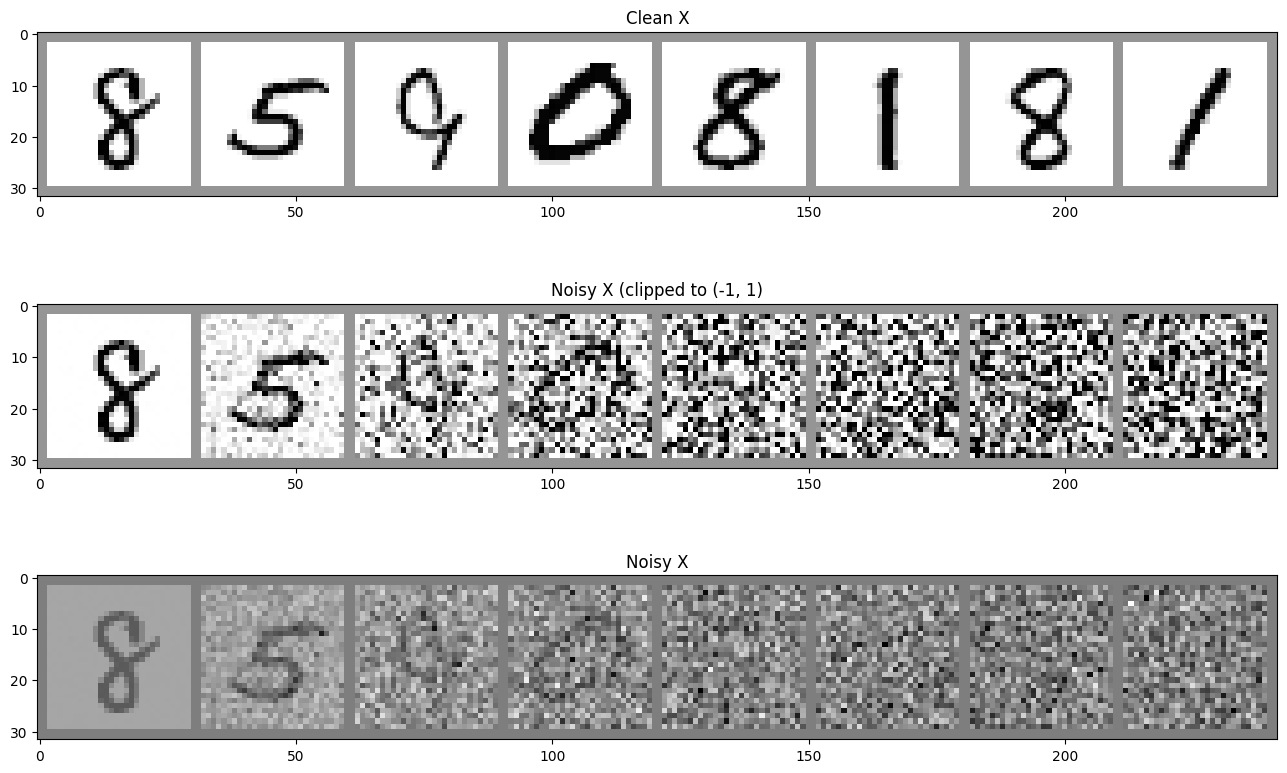

In [62]:
"""
可视化：DDPM加噪过程中的不同时间步
"""
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
# print('X shape:', xb.shape,'X:',xb)  # torch.Size([128, 1, 28, 28])
xb = xb.to(device)[:8]  # 取出前8个
xb = xb * 2. - 1. # Map to (-1, 1)
# print('X shape:', xb.shape,'X:',xb)  # torch.Size([8, 1, 28, 28])

# Show clean inputs（展示干净的原始输入）
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler（使用调度器加噪）
timesteps = torch.linspace(0, 999, 8).long().to(device)  # torch.Size([8])
noise = torch.randn_like(xb) # << NB: randn（标准高斯分布） not rand（均匀分布）# torch.Size([8, 1, 28, 28])
# print(timesteps.shape,noise.shape)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
# print('Noisy X shape:', noisy_xb.shape)  # torch.Size([8, 1, 28, 28])

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),cmap='Greys')
axs[2].set_title('Noisy X')

In [ ]:
"""
使用模型预测加噪过程中的噪声
"""

noise=torch.randn_like(xb)
noisy_x=noise_scheduler.add_noise(x,noise,timesteps)
model_prediction=model(noisy_x,timesteps).sample
loss=nn.MSELoss(model_prediction,noise)